# Deep learning for text and sequences

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Working with text data

In the age of information, text is everywhere. It can be understood either as a sequence of characters or a sequence of words. However, we cannot simply input raw text to a neural network. Like other machine learning tasks, the text must be encoded (vectorized) into a numeric tensor that describes the text. This can be done in many ways which we will explore below: 
* Segmenting text into words and transforming each word into a vector
* Segmenting text into characters and transforming each character into a vector
* Extracting `n-grams` of words or characters and tranforming each n-gram into a vector <br> (`n-grams` are overlapping groups of multiple consecutive words or characters)

### One-hot encoding of words or characters

One-hot encoding is the most common, most basic way to turn a token into a vector. It consists in associating a unique index to every word, then turning this index i into a vinary vector of size N. One-hot encoding can alos be done at the charicter level as well. 

As a quick exercise, we will implement the one-hot encoding of words ourself. 

In [2]:
samples = [
    'The cat sat on the mat',
    'The dog ate my homework',
    ]

In [3]:
token_index = {}
for sample in samples:
    sample = sample.lower()
    for word in sample.split():
        # In real life we should strip the punctuation, I will skip this 
        #    in my exercise because in practice I will use a library.
         if word not in token_index:
            token_index[word] = len(token_index) + 1
            # note: we do not associate index 0 to anything. 

In [4]:
# limit the vector space to only the top N words.
max_length = 10

results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index[word.lower()]
        results[i, j, index] = 1

In [5]:
results

array([[[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,

We can of course to this using built-in utilities with keras. This will better handle any special characters and exceptions that we might encounter. 

In [6]:
from keras.preprocessing.text import Tokenizer

# Builds the word index
tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts(samples)

# Turns strings into lists of indices
sequences = tokenizer.texts_to_sequences(samples)

# One-hot binary representations (a little different than before)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

Using TensorFlow backend.


In [7]:
one_hot_results

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.]])

### Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". In contrast to one-hot encoding, word embeddings are low-dimensional floating point vectors which are learned from data. It is common to see word embeddings that are 255, 512, or 1024-dimensional when dealing with very large vocabularies; able to pack more information into far fewer dimensions than one-hot encoding.

#### Learning word embeddings

The geometric relationships between word vectors reflect the semantic relationships between these words. Word embeddings are meant to map human language into a vector space. A common example for meaningful gemetric transformations are "gender" and "plural" vectors. For instance, by adding a "female" vector to the vector "king", one may obtain the vector "queen". By adding a "plural" vector, one obtains "kings". Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors. 

A physicist or lawyer typically uses a different set of language in their day-to-day lives. Similarly, the optimal word embedding depends on the context of your task: an optimal word embedding for art critique sentiment model may look very different from the perfect embedding space for a legal document classification model. Thus, it is reasonable to learn a new embedding space with each new task. Keras makes this very easy. 

In [8]:
from keras.layers import Embedding

# The embedding takes two arguments
#    1. The number of possible tokens (1000)
#    2. The dimensionality of the embeddings (64)
embedding_layer = Embedding(1000, 64)

When you instatiate an `Embedding` layer, its weights are initially random. Of course this isn't very effivient, so it must be trained to your domain. Let's apply this idea to IMDB movie review sentiment prediction. We will restrict the movie reviews to the top 10k most common words and cut the reviews after only 20 words.

In [9]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words
maxlen = 20

# Load the data as lists of integers
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Turn our lists of integers into a 2D tensor of integers with shape '(samples, maxlen)'
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = preprocessing.sequence.pad_sequences(X_test,  maxlen=maxlen)

Our network will simply learn 8-dimensional embeddings for each fo the 10k words, turn the integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` layer on top for classification.

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


Considering we only look at the first 20 words in every review, a validation accuracy of ~76% is pretty impressive! 

By only flattening the embedded sequences and training a single `Dense` layer the model treats each word individually, without considering inter-word relations and sentence structure. Such a model would likely treat both *"this movie is shit"* and *"this movie is the shit"* as both being negative reviews. It would be much better to add recurrent layers or a 1D convolution layer on top of the embedded sequences to learn features that take into account the full sentence. We will try both of these options later on in the notebook.

In [11]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s - loss: 0.6560 - acc: 0.6482 - val_loss: 0.5906 - val_acc: 0.7146
Epoch 2/10
20000/20000 [==============================] - 2s - loss: 0.5189 - acc: 0.7595 - val_loss: 0.5117 - val_acc: 0.7364
Epoch 3/10
20000/20000 [==============================] - 2s - loss: 0.4512 - acc: 0.7933 - val_loss: 0.4949 - val_acc: 0.7470
Epoch 4/10
20000/20000 [==============================] - 2s - loss: 0.4190 - acc: 0.8069 - val_loss: 0.4905 - val_acc: 0.7538
Epoch 5/10
20000/20000 [==============================] - 2s - loss: 0.3965 - acc: 0.8198 - val_loss: 0.4914 - val_acc: 0.7572
Epoch 6/10
20000/20000 [==============================] - 2s - loss: 0.3784 - acc: 0.8311 - val_loss: 0.4953 - val_acc: 0.7594
Epoch 7/10
20000/20000 [==============================] - 2s - loss: 0.3624 - acc: 0.8419 - val_loss: 0.5004 - val_acc: 0.7574
Epoch 8/10
20000/20000 [==============================] - 2s -

#### Using Pre-Trained Word Embeddings

Sometimes, you might have so little data available that you could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. Instead of learning word embeddings jointly with the problem you want to solve (as we just di), you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures general aspects of language structure. The rationale behind using pre-trained word embeddings in NLP is very much the same as that of using pre-trained convnets in image classification: we don't have enough data to learn the optimal features for a problem, but we expect the features that we need to be fairly generic.

While not the first, the most famous and successful word embedding algorithm is `Word2Vec`. There are many pre-computed databases of word embeddings included in keras; `Word2Vec` is one of them. Another popular choice is called "GloVe" (Global Vectors for Word Representation), it is an embedding technique based on factorizing a matrix of word co-occurence statistics.

#### From Raw text to word embeddings
Let's put everything together but using raw (pre-tokenized) IMBD data and a pre-trained word embedding.  

In [20]:
# Collect and label the training data
imdb_dir = 'raw_text'
train_dir = os.path.join(imdb_dir, 'train')

texts, labels = [], []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='latin-1')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Now we'll vectorize the texts we collected and prepare a training and validation split. Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available, we will restrict the training data to only the first 200 samples. We will still use a 10k sample validation set to see how well we do. 

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100 
max_words = 10000
training_samples = 200
validation_samples = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Shuffle data before splitting the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
labels = labels[indices]
data = data[indices]

X_train = data  [:training_samples]
y_train = labels[:training_samples]
X_val   = data  [training_samples: training_samples + validation_samples]
y_val   = labels[training_samples: training_samples + validation_samples]

Found 88596 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (50000,)


I downloaded the GloVe training created by crawling Wikipedia 2014 + Gigaword 5, but we need to do some pre-processing of the embedding.

In [22]:
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer

In [23]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Let's define the same model architecture as before.

In [24]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


One slight tweak however, is that we want to use our pre-trained embedding instead of training a new one. We do this by loading in our pre-trained weights and freezing the layer so that it will not be altered during training.

In [25]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Finally, let's train and evaluate our model:

In [47]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 70s - loss: 0.1754 - acc: 0.9391 - val_loss: 1.0182 - val_acc: 0.4864
Epoch 2/10
25000/25000 [==============================] - 69s - loss: 0.1483 - acc: 0.9484 - val_loss: 1.0376 - val_acc: 0.4884
Epoch 3/10
25000/25000 [==============================] - 65s - loss: 0.1352 - acc: 0.9544 - val_loss: 1.0906 - val_acc: 0.4874
Epoch 4/10
25000/25000 [==============================] - 65s - loss: 0.1304 - acc: 0.9554 - val_loss: 1.1385 - val_acc: 0.4900
Epoch 5/10
25000/25000 [==============================] - 66s - loss: 0.1217 - acc: 0.9594 - val_loss: 1.1941 - val_acc: 0.4901
Epoch 6/10
25000/25000 [==============================] - 65s - loss: 0.1068 - acc: 0.9638 - val_loss: 1.1370 - val_acc: 0.4917
Epoch 7/10
25000/25000 [==============================] - 66s - loss: 0.1076 - acc: 0.9638 - val_loss: 1.2021 - val_acc: 0.4891
Epoch 8/10
25000/25000 [==============================

Let's plot the performance over each epoch of training

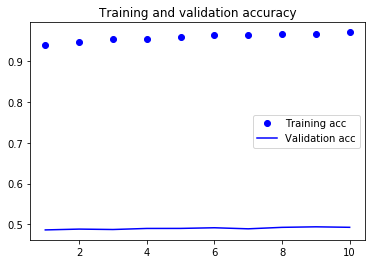

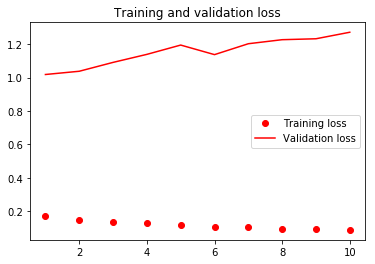

In [48]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s. This is pretty low, but with such a small training set it is not unexpected.

Before moving forward, let's take quick inventory of what we can do:
   * Turn raw text into something that a neural net can process
   * Use the `Embedding` layer to learn task-specific token embeddings
   * Leverage pre-trained word embeddings to get an extra boost on NLP problems with limited data

## Recurrent Neural Nets

A major characteristic of most neural networks, such as densely-connected networks and convnets, is that they have no memory. Each input to them gets processed independently, with no state kept in-between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entrie sequence to the network at once; i.e. turn it into a single datapoint. Such networks are called "feedforward networks". 

Recurrent Neural Networks (RNNs) process sequences by iterating through the sequence and maintaining a "state" containing information relative to what they have seen so far; i.e. these networks maintain some of the context of a sequence. In effect, RNNs are a type of neural network that has an internal loop. The state of the RNN is reset in-between processing two different, independent sequences, so we still consider one sequence as a single datapoint, a single input into the network -- what changes is that this datapoint is no longer processed in a single step, rather, the network internally loops over sequence elements.

In general, this is too much of an oversimplification to have any real use. In state-of-the-art RNN models, one would typically use a `LSTM` (Long-Short Term Memory) or `GRU` (Gated Recurrent Units) layers. These variants help to solve the vanishing gradient problem and hence have longer memories than a simple RNN. We will not get into the details of how these two layers work but to say that they offer a way of saving information for later use. The GRU layer runs on the same principle but is somewhat streamlined and is thus cheaper to run, although it might not have quite as much representational power as the LSTM.

In [49]:
# Reload the dataset
maxlen = 500
max_features = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = preprocessing.sequence.pad_sequences(X_test,  maxlen=maxlen)

In [50]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 58s - loss: 0.5710 - acc: 0.7231 - val_loss: 0.4190 - val_acc: 0.8366
Epoch 2/10
20000/20000 [==============================] - 56s - loss: 0.3360 - acc: 0.8681 - val_loss: 0.3378 - val_acc: 0.8618
Epoch 3/10
20000/20000 [==============================] - 56s - loss: 0.2577 - acc: 0.9009 - val_loss: 0.3904 - val_acc: 0.8638
Epoch 4/10
20000/20000 [==============================] - 55s - loss: 0.2196 - acc: 0.9172 - val_loss: 0.3740 - val_acc: 0.8660
Epoch 5/10
20000/20000 [==============================] - 56s - loss: 0.1902 - acc: 0.9293 - val_loss: 0.2864 - val_acc: 0.8862
Epoch 6/10
20000/20000 [==============================] - 55s - loss: 0.1722 - acc: 0.9368 - val_loss: 0.4893 - val_acc: 0.8218
Epoch 7/10
20000/20000 [==============================] - 57s - loss: 0.1582 - acc: 0.9415 - val_loss: 0.4694 - val_acc: 0.8426
Epoch 8/10
20000/20000 [==============================]

In [51]:
def plot_history(history):
    acc      = history.history['acc']
    val_acc  = history.history['val_acc']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

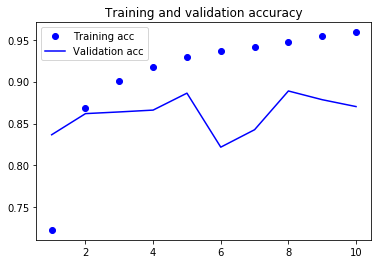

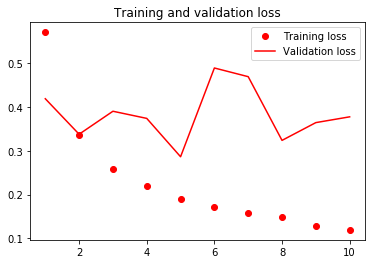

In [52]:
plot_history(history)

So we achieve a validation accuracy of ~85%; not bad considering we are truncating the full sequences. On the other hand, it is also not groundbreaking. One might do better by optimizing the hyperparmeters of the model, such as the dimensionality of the embeddings or LSTM. We might also benefit by some regularization. But honestly, the reason is mostly that analyzing the global, long-term structure of reviews (what LSTM is really good at) isn't very helpful for a sentiment analysis problem. Such a basic problem is very well solved by simply looking at what words occur in each review and at what frequency. But there are far more difficult NLP problems out there, where the strength of LSTM will become apparent: in particular, question answering and machine translation. 

### Recurrent Dropout

Dropout is used frequently to fight over-fitting in typical feedforward neural nets, consisting of randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. However, to corretly apply dropout in recurrent networks is not trivial. Instead of applying a random dropout mask for each timestep, you must instead apply the same dropout mask for each timestep of a series. What's more: in order to regularize the repressentations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process. 

Let's add dropout to our LSTM layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs. 

In [55]:
from keras.optimizers import RMSprop
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 61s - loss: 0.6121 - acc: 0.7085 - val_loss: 0.4945 - val_acc: 0.8128
Epoch 2/20
20000/20000 [==============================] - 58s - loss: 0.4447 - acc: 0.8229 - val_loss: 0.4299 - val_acc: 0.8178
Epoch 3/20
20000/20000 [==============================] - 56s - loss: 0.3599 - acc: 0.8547 - val_loss: 0.3680 - val_acc: 0.8476
Epoch 4/20
20000/20000 [==============================] - 56s - loss: 0.3127 - acc: 0.8794 - val_loss: 0.4141 - val_acc: 0.8178
Epoch 5/20
20000/20000 [==============================] - 55s - loss: 0.2867 - acc: 0.8883 - val_loss: 0.3415 - val_acc: 0.8562
Epoch 6/20
20000/20000 [==============================] - 55s - loss: 0.2593 - acc: 0.9028 - val_loss: 0.3642 - val_acc: 0.8618
Epoch 7/20
20000/20000 [==============================] - 56s - loss: 0.2494 - acc: 0.9075 - val_loss: 0.3643 - val_acc: 0.8420
Epoch 8/20
20000/20000 [==============================]

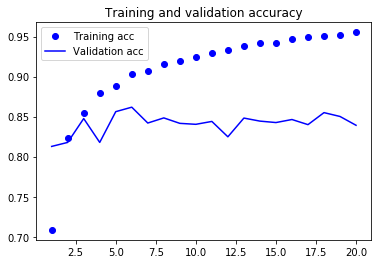

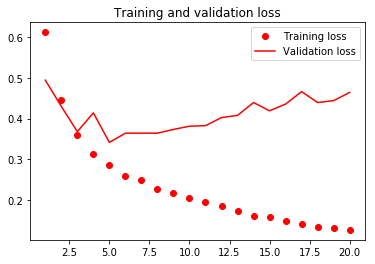

In [58]:
plot_history(history)

Hmm, dropout is stopping over-training very little and the performance is a bit lower. We likely are using too compex of a model for the input data and task at hand but we will proceed forward as if we are undertraining for the sake of exercising more powerful techniques that may be useful given more powerful tasks at hand. 

## Stacking Recurrent Layers

Once we are no longer overfitting, we seem to hit a performance bottleneck with our model, hence we should start considering increasing the capactity of our network. Generally, it is a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Stacking recurrent layers is a classic way to build more powerful recurent networks: for instance, what curently powers the Google translate algorithm is a powerful stack of seven large LSTM layers -- huge. 

To stack recurrent layers in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is easily done by specifying `return_sequences=True`.

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 111s - loss: 0.5662 - acc: 0.7058 - val_loss: 0.4270 - val_acc: 0.8192
Epoch 2/20
20000/20000 [==============================] - 110s - loss: 0.3993 - acc: 0.8333 - val_loss: 0.4952 - val_acc: 0.7802
Epoch 3/20
20000/20000 [==============================] - 107s - loss: 0.3416 - acc: 0.8620 - val_loss: 0.3902 - val_acc: 0.8376
Epoch 4/20
20000/20000 [==============================] - 110s - loss: 0.3041 - acc: 0.8797 - val_loss: 0.3827 - val_acc: 0.8432
Epoch 5/20
20000/20000 [==============================] - 110s - loss: 0.2876 - acc: 0.8878 - val_loss: 0.4290 - val_acc: 0.8126
Epoch 6/20
20000/20000 [==============================] - 112s - loss: 0.2579 - acc: 0.9005 - val_loss: 0.4278 - val_acc: 0.8166
Epoch 7/20
20000/20000 [==============================] - 108s - loss: 0.2448 - acc: 0.9049 - val_loss: 0.3902 - val_acc: 0.8390
Epoch 8/20
20000/20000 [========================

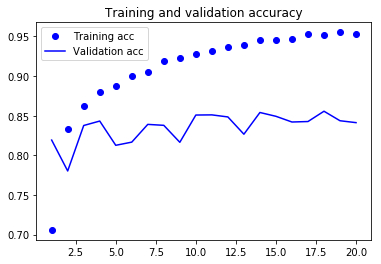

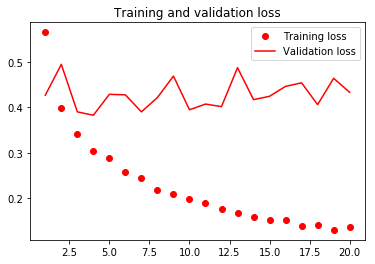

In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)
plot_history(history)

Here, we can draw two conclusions
* Since we are not overfitting too badly, we could safely increase the size of our layers for a bit of validation loss improvement. However, this does not have negligible computational costs. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing the network capacity at this point.

## Bidirectional RNNs

Let's also quickly explore the technique of "bidirectional" RNNs. A biderectional RNN is a common RNN variant that can offer higher performance over a regular RNN on certain tasks. It is frequently used in NLP processing. 

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the representations can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why the perform wll on problems where order is meaningful, such as time-series problems. A biderectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the LSTM layers, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both ways, a bidirectional RNN is able to catch patters that may have been overlooked by a one-direction RNN.

Feeding information into our RNNs in chronological order is an arbitrary decision. Typically with a time series problem, it makes sense to process things chronologically. The RNN will be better at remembering (and making decisions) with the last data point in the series -- but this is not generally true, especially in NLP analysis. By taking information in antichronologically we might better capture the context of the text for sentiment prediction. 

In [76]:
from keras.preprocessing import sequence
(Xr_train, yr_train), (Xr_test, yr_test) = imdb.load_data(num_words=max_features)

# Reverse the sequences
Xr_train = [x[::-1] for x in Xr_train]
Xr_test = [x[::-1] for x in Xr_test]

# Pad thes sequences
Xr_train = sequence.pad_sequences(Xr_train, maxlen=maxlen)
Xr_test = sequence.pad_sequences(Xr_test, maxlen=maxlen)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 57s - loss: 0.5263 - acc: 0.7380 - val_loss: 0.3809 - val_acc: 0.8524
Epoch 2/10
20000/20000 [==============================] - 56s - loss: 0.3353 - acc: 0.8678 - val_loss: 0.3470 - val_acc: 0.8598
Epoch 3/10
20000/20000 [==============================] - 58s - loss: 0.2682 - acc: 0.9008 - val_loss: 0.3821 - val_acc: 0.8756
Epoch 4/10
20000/20000 [==============================] - 57s - loss: 0.2285 - acc: 0.9136 - val_loss: 0.3561 - val_acc: 0.8818
Epoch 5/10
20000/20000 [==============================] - 57s - loss: 0.2088 - acc: 0.9240 - val_loss: 0.3361 - val_acc: 0.8742
Epoch 6/10
20000/20000 [==============================] - 56s - loss: 0.1845 - acc: 0.9330 - val_loss: 0.7995 - val_acc: 0.8104
Epoch 7/10
20000/20000 [==============================] - 57s - loss: 0.1719 - acc: 0.9405 - val_loss: 0.3837 - val_acc: 0.8598
Epoch 8/10
20000/20000 [==============================]

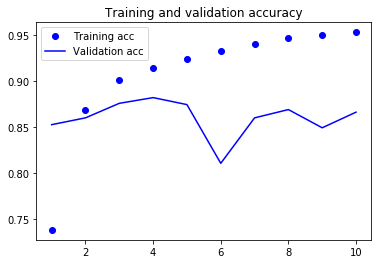

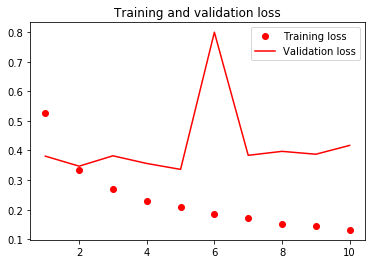

In [78]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(Xr_train, yr_train, epochs=10, batch_size=256, validation_split=0.2)
plot_history(history)

So we get very similar performance to the chronological-order LSTM we tried in the previous section. Hence we can conclude that while word order does matter in understanding language, *which* order isn't crucial. Importantly, a RNN trained on reverse sequences will learn different representations than the one trained on the original sequences. In machine learning, representations that are different yet useful are always worth expliting as they can boost performance through ensembling. Let's implent a bidirectional RNN below:

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 106s - loss: 0.6398 - acc: 0.6547 - val_loss: 0.5445 - val_acc: 0.7532
Epoch 2/10
20000/20000 [==============================] - 104s - loss: 0.4466 - acc: 0.8202 - val_loss: 0.4008 - val_acc: 0.8464
Epoch 3/10
20000/20000 [==============================] - 108s - loss: 0.3157 - acc: 0.8810 - val_loss: 0.7835 - val_acc: 0.6796
Epoch 4/10
20000/20000 [==============================] - 104s - loss: 0.2671 - acc: 0.8998 - val_loss: 0.3072 - val_acc: 0.8844
Epoch 5/10
20000/20000 [==============================] - 104s - loss: 0.2269 - acc: 0.9178 - val_loss: 0.4254 - val_acc: 0.8668
Epoch 6/10
20000/20000 [==============================] - 105s - loss: 0.1997 - acc: 0.9298 - val_loss: 0.3837 - val_acc: 0.8662
Epoch 7/10
20000/20000 [==============================] - 104s - loss: 0.1853 - acc: 0.9360 - val_loss: 0.4046 - val_acc: 0.8522
Epoch 8/10
20000/20000 [========================

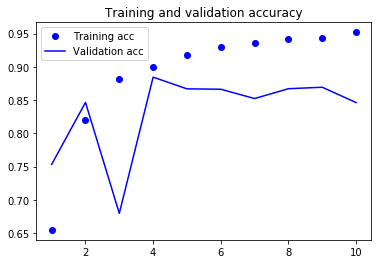

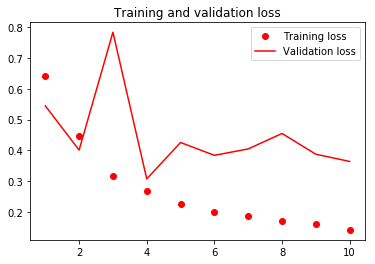

In [80]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(Xr_train, yr_train, epochs=10, batch_size=256, validation_split=0.2)
plot_history(history)

We maybe do slightly better but we also seem to overtrain quite quickly, this isn't surprising considering that the bidirectional RNN has twice the parameters.

## Going even further
At this stage, there are still many things one could try in order to improve the performance on sentiment analysis problem: 
* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and likely sub-optimal
* Adjust the learning rate used by our RMSprop optimizer
* Try using GRU layers instead of LSTM layers
* Try using a bigger densely-connected classifier on top of the recurrent layers
* Try optimizing the drop-out and recurrent drop-out used in regularization 
* Try the best performing models on our test set, to avoid over-fitting the validation set. 

This of course is quite extensive for this exercise and will be left for true projects later on. Let's look into understanding sequnces with convnets.

# Sequence processing with convnets

2D CNNs are particularly well suited to computer vision problems, due to their ability to operate convolutionally: extracting features from local input patches, allowing for representation modularity and data efficiency. The same properties that make a 1D convolution highly relevant to sequence processing by treating time as a spatial dimension.

Such 1D CNNs can be competitive with RNNs on certain sequence processing problems, usually at a considerably cheaper computational cost. Recently, 1D CNNs, typically used with dilated kernels, have been used with great sucess for audio generation and machine translation. And besides these specific success, it has been known that small 1D CNNs can offer a fast alternative to RNNs for simple tasks such as text classification or timeseries forecasting. 

## Understanding 1D convolution and pooling for sequence data

A 1D CNN can extract local 1D patches (sub-sequences) out of sequences -- hence, such 1D convolution layers will be able to recognize local patterns in a sequence. Because the same input transformation is perfored on every patch, a patterned learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant. For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn about words or word fragments of length 5 or lower, and should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus capable to learn about word morphology. 

Additionally, we can use 1D pooling to downsample -- similar to 2D pooling in computer vison problems. 

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s - loss: 0.5425 - acc: 0.7255 - val_loss: 0.3513 - val_acc: 0.8518
Epoch 2/20
20000/20000 [==============================] - 1s - loss: 0.2911 - acc: 0.8813 - val_loss: 0.2985 - val_acc: 0.8756
Epoch 3/20
20000/20000 [==============================] - 1s - loss: 0.2163 - acc: 0.9139 - val_loss: 0.3788 - val_acc: 0.8474
Epoch 4/20
20000/20000 [==============================] - 1s - loss: 0.1677 - acc: 0.9390 - val_loss: 0.3141 - val_acc: 0.8780
Epoch 5/20
20000/20000 [==============================] - 1s - loss: 0.1310 - acc: 0.9526 - val_loss: 0.4056 - val_acc: 0.8530
Epoch 6/20
20000/20000 [==============================] - 1s - loss: 0.0968 - acc: 0.9681 - val_loss: 0.3790 - val_acc: 0.8752
Epoch 7/20
20000/20000 [==============================] - 1s - loss: 0.0713 - acc: 0.9778 - val_loss: 0.4061 - val_acc: 0.8704
Epoch 8/20
20000/20000 [==============================] - 1s -

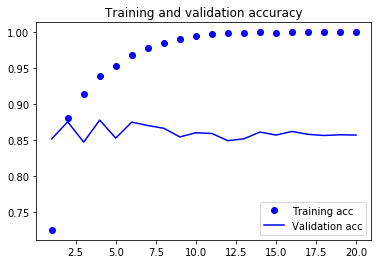

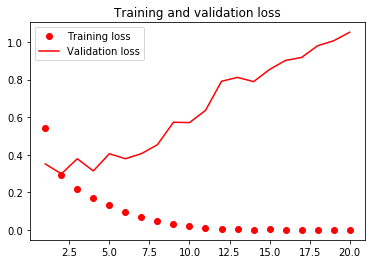

In [83]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
#model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)
plot_history(history)

The validation accuracy is maybe a tad lower than what we saw with the RNNs but wow this was so much faster! Since this model being so efficient, it would be much easier to optimize and improve performance. 

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale), unlike RNNs. Of course, in order to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a fairly weak way to induce order-sensitivity. 

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s - loss: 0.5950 - acc: 0.6491 - val_loss: 0.4181 - val_acc: 0.8122
Epoch 2/20
20000/20000 [==============================] - 1s - loss: 0.3356 - acc: 0.8573 - val_loss: 0.3289 - val_acc: 0.8618
Epoch 3/20
20000/20000 [==============================] - 1s - loss: 0.2424 - acc: 0.9041 - val_loss: 0.3044 - val_acc: 0.8780
Epoch 4/20
20000/20000 [==============================] - 1s - loss: 0.2027 - acc: 0.9216 - val_loss: 0.3989 - val_acc: 0.8486
Epoch 5/20
20000/20000 [==============================] - 1s - loss: 0.1545 - acc: 0.9403 - val_loss: 0.4915 - val_acc: 0.8314
Epoch 6/20
20000/20000 [==============================] - 1s - loss: 0.1212 - acc: 0.9563 - val_loss: 0.4571 - val_acc: 0.8618
Epoch 7/20
20000/20000 [==============================] - 1s - loss: 0.0932 - acc: 0.9666 - val_loss: 0.6258 - val_acc: 0.8346
Epoch 8/20
20000/20000 [==============================] - 1s -

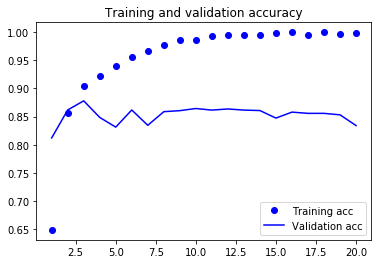

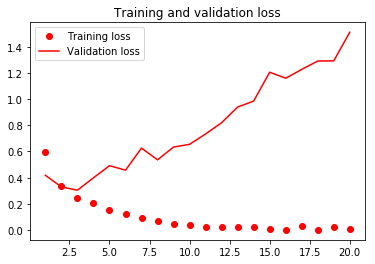

In [87]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
#model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)
plot_history(history)

So even by greatly expanding the network we don't gain much improvement in the validation accuracy (of course we're still overtraining things). However, one alternative strategy to combine the speed and lightness of CNNs with the order-sensitivity of RNNs is to use a 1D CNN as a preprocessing step before an RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed with RNNs, e.g. sequences with thousands of steps. The CNN will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network. 


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 23s - loss: 0.5383 - acc: 0.7174 - val_loss: 0.3425 - val_acc: 0.8624
Epoch 2/10
20000/20000 [==============================] - 20s - loss: 0.3401 - acc: 0.8619 - val_loss: 0.3746 - val_acc: 0.8380
Epoch 3/10
20000/20000 [==============================] - 20s - loss: 0.2685 - acc: 0.8947 - val_loss: 0.4094 - val_acc: 0.8344
Epoch 4/10
20000/20000 [==============================] - 21s - loss: 0.2175 - acc: 0.9191 - val_loss: 0.4001 - val_acc: 0.8482
Epoch 5/10
20000/20000 [==============================] - 20s - loss: 0.1853 - acc: 0.9322 - val_loss: 0.3580 - val_acc: 0.8714
Epoch 6/10
20000/20000 [==============================] - 20s - loss: 0.1533 - acc: 0.9462 - val_loss: 0.3623 - val_acc: 0.8738
Epoch 7/10
20000/20000 [==============================] - 20s - loss: 0.1297 - acc: 0.9555 - val_loss: 0.4187 - val_acc: 0.8602
Epoch 8/10
20000/20000 [==============================]

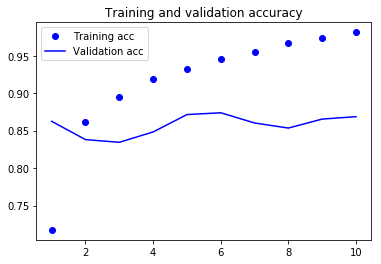

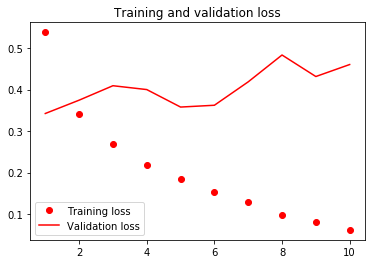

In [92]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2)
plot_history(history)

So judging by the validation accuracy, it seems that this model does similar or slightly better than the standard RNN -- but it is significantly faster and capable of looking at much larger strings of text (which could improve the performance further).

# Take Aways

So we've done several things in this notebook:
* Tokenized text
* Used word embeddings
* Used RNNs including extensions such as stacked RNN layers and bidirectional RNNs
* Implemented recurrent dropout for RNNs
* Used 1D Convolutional Neural Nets
* Stacked 1D CNNs with RNNs

These techniques are widely applicable to any dataset of sequence data, from text to timeseries. For instance, you could use RNNs for:
* Timeseries regression and classification
* Anomaly detection in timeseries
* Sequence labeling, e.g. identifying names or dates in sentences
* etc. 

Similarly, you could use 1D convnets for:
* Machine tranlsation
* Document classification
* Spelling correction
* etc. 

Remember: if *global order* matters in your sequence data, then it is preferable to use a RNN to proces it. This is typcially the case for timeseries, where the recent past is likely to be more infomative than the distant past. But if global ordering isn't fundamentally meaningful, then 1D CNNs will turn out to work at least as well, while being far cheaper. This is often the case for text data, where a keyword found at the beginning of a sentence is just as meaningful as a keyword found at the end. 